In [16]:
import os
import numpy as np
import torch
torch.cuda.empty_cache()
import matplotlib.pyplot as plt
from torch.utils.data import Dataset
import pandas as pd
import cv2
from torchvision.utils import draw_bounding_boxes
from torch.utils.data import DataLoader
from torchvision import transforms as T
from PIL import Image
import random

vid_4_600.jpg


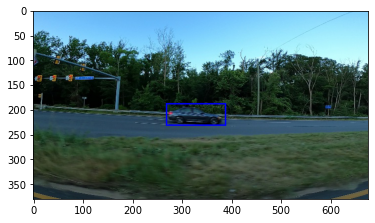

vid_4_620.jpg


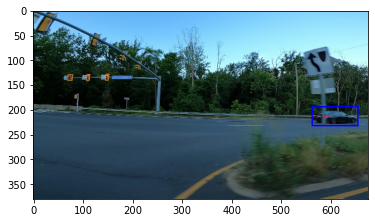

vid_4_680.jpg


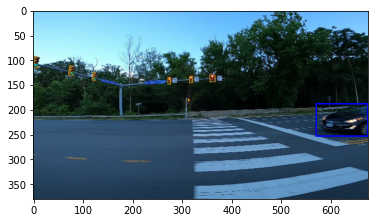

vid_4_700.jpg


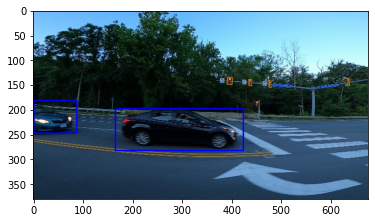

vid_4_700.jpg


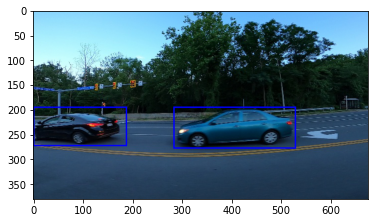

In [17]:
def randomflip(img,bb):
    if(random.random()>0.5):
        #img shape : (3,H,W)
        img = torch.flip(img,[2])
        bb_old = bb.clone()
        bb_old[:,0] /= img.shape[2]
        bb_old[:,2] /= img.shape[2]
        
        bb[:,0] = 1 - bb_old[:,2]
        bb[:,2] = 1 - bb_old[:,0]
        
        bb[:,0] *= img.shape[2]
        bb[:,2] *= img.shape[2]
    return(img,bb)
        
class Car_data(Dataset):
    def __init__(self,transform=None,transform_labels=None):
        super().__init__()
        self.transform = transform
        self.transform_labels = transform_labels
        self.car_img_df = pd.read_csv("train_solution_bounding_boxes(1).csv")
        self.car_id_df = pd.read_csv("Img_Ids.csv")
    
    def __len__(self):
        return self.car_id_df.shape[0]
        
    def __getitem__(self,idx):
        img = Image.open(os.path.join(r"C:\Users\KARTIK BALI\Desktop\I2DL\archive\data\training_images",
                                      self.car_id_df.loc[idx]["image"]))
        boxes = self.car_img_df.loc[self.car_img_df['image']==self.car_id_df.loc[idx,'image'],["xmin","ymin","xmax","ymax"]].values
        #img = np.transpose(img,(2,0,1))
        if self.transform_labels:
            boxes = self.transform_labels(boxes)
        
        area = (boxes[:,2] - boxes[:,0]) * (boxes[:,3] - boxes[:,1])
        
        img = T.ToTensor()(img)
        img,boxes = randomflip(img,boxes)
        default_img = img
        
        if self.transform:
            img = self.transform(img)
    
        labels = torch.ones(boxes.shape[0],dtype=torch.int64)
        iscrowd = torch.zeros(boxes.shape[0],dtype=torch.int64)
        
        img_index = torch.tensor(idx,dtype=torch.int64)
        target = {'boxes':boxes, 'labels':labels, 'image_id':img_index, 'area':area, 'iscrowd':iscrowd}
        return img,target,default_img

#For Faster RCNN Model
trainable_dataset = Car_data(transform = T.Compose([T.Normalize(mean=[0.485, 0.456, 0.406],
                                                                                          std=[0.229, 0.224, 0.225])]),
                             transform_labels = torch.Tensor)
def visualize_bb(indxs,colors="blue"):
    img_id_df = pd.read_csv("Img_Ids.csv")
    img_csv_df = pd.read_csv("train_solution_bounding_boxes(1).csv")
    for i in indxs:
        print(img_csv_df.loc[i]["image"])
        img = Image.open(os.path.join(r"C:\Users\KARTIK BALI\Desktop\I2DL\archive\data\training_images",
                                      img_id_df.loc[i]["image"]))
        img = T.ToTensor()(img) * 255
        b_boxes = img_csv_df.loc[img_csv_df['image']==img_id_df.loc[i,'image'],["xmin","ymin","xmax","ymax"]].values
        b_box = torch.tensor(b_boxes,dtype = torch.float)
        
        img, b_box = randomflip(img, b_box)
        
        labels = torch.ones(b_box.shape[0],dtype=torch.int64)
        resulting_img = draw_bounding_boxes(img.byte(),boxes = b_box,
                                            width=3,colors = colors)
        #resulting_img.shape -> (C,H,W)
        #unsqueeze adds a 1 at the dimension specified. for ex. for list with shape (2,), list.unsqueeze(1)-> shape: (2,1)
        plt.imshow(resulting_img.permute(1,2,0))
        #permute is not the same as reshape, it transposes the img tensor such that image become (H,W,C) as suited for plotting 
        #in matplotlib
        plt.show()

visualize_bb([i for i in range(5)])

In [18]:
def collate_fn(batch):
    return tuple(zip(*batch))

train_len = int(0.8*len(trainable_dataset))
val_len = len(trainable_dataset) - train_len
train_dataset, val_dataset = torch.utils.data.random_split(trainable_dataset,[train_len,val_len])
batch_size = 1
train_dataloader = DataLoader(dataset = train_dataset,shuffle = True, batch_size=batch_size,collate_fn = collate_fn)
val_dataloader = DataLoader(dataset = val_dataset,shuffle = True, batch_size=batch_size,collate_fn = collate_fn)

In [19]:
import torch.nn as nn
import torchvision
from torchvision.models.detection import FasterRCNN
from torchvision.models.detection.faster_rcnn import FastRCNNPredictor
from torchvision.models.detection.rpn import AnchorGenerator
from torch.utils.tensorboard import SummaryWriter
writer = SummaryWriter()

model = torchvision.models.detection.fasterrcnn_resnet50_fpn(pretrained=True)
num_classes = 2 #car + background
in_features = model.roi_heads.box_predictor.cls_score.in_features
model.roi_heads.box_predictor = FastRCNNPredictor(in_features, num_classes)

In [20]:
import gc

loss_fn = torch.nn.MSELoss()
params = [param for param in model.parameters() if param.requires_grad]

#optimizer = torch.optim.Adam(params,lr=1e-5)

optimizer = torch.optim.SGD(params, lr=0.005, momentum=0.9, weight_decay=0.0005)
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=4, gamma=0.1)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

model = model.to(device)

##training loop
def training_loop(train_dataloader,loss_fn,optimizer,epoch,batch_size):
    train_loss = 0
    num_batches = 1
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    for images,targets,_ in train_dataloader:
        images = list(image.to(device) for image in images)
        targets = [{k:v.to(device) for k,v in t.items()} for t in targets]
        
        loss_dict = model(images,targets)
        losses = sum(loss for loss in loss_dict.values())
        
        optimizer.zero_grad()
        losses.backward()
        optimizer.step()
        train_loss += losses.item()
        num_batches += 1
        
        #Free CUDA Memory
        del images,targets
        gc.collect()
        torch.cuda.empty_cache()
    print(" Train_loss:",train_loss/num_batches,end="")
    writer.add_scalar("Training Loss",train_loss/num_batches,epoch)
        
def validation_loop(val_dataloader,loss_fn,epoch,batch_size):
    val_loss = 0
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    num_batches = 1
    for images,targets,_ in val_dataloader:
        images = [image.to(device) for image in images]
        targets = [{k:v.to(device) for k,v in t.items()} for t in targets]
        
        loss_dict = model(images,targets)
        losses = sum(loss for loss in loss_dict.values())
        val_loss+= losses.item()
        num_batches += 1
        
        #Free CUDA Memory
        del images,targets
        gc.collect()
        torch.cuda.empty_cache()
    print(" Val_loss:",val_loss/num_batches)
    writer.add_scalar("Val Loss",val_loss/num_batches,epoch)

num_epochs=5
for epoch in range(num_epochs):
    print("Epoch: ",epoch,"/",num_epochs,end="")
    training_loop(train_dataloader, loss_fn, optimizer, epoch,batch_size)
    validation_loop(val_dataloader, loss_fn, epoch,batch_size)
    writer.flush()

Epoch:  0 / 5 Train_loss: 0.20347544805783974 Val_loss: 0.1525718052354124
Epoch:  1 / 5 Train_loss: 0.13275016273061435 Val_loss: 0.12138689873326156
Epoch:  2 / 5 Train_loss: 0.1182464875215501 Val_loss: 0.11839291955240899
Epoch:  3 / 5 Train_loss: 0.09961183698553788 Val_loss: 0.1258168305373854
Epoch:  4 / 5 Train_loss: 0.09222561573903812 Val_loss: 0.10681408028014833


tensor([[614.1749, 197.2483, 676.0001, 237.6503]], grad_fn=<StackBackward0>)


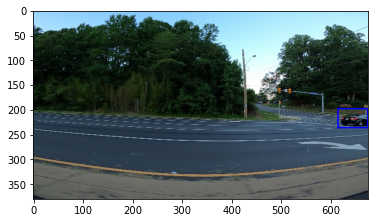

tensor([[622.2177, 193.3154, 675.7806, 234.8249],
        [515.0899, 197.5894, 561.8689, 217.6884]], grad_fn=<StackBackward0>)


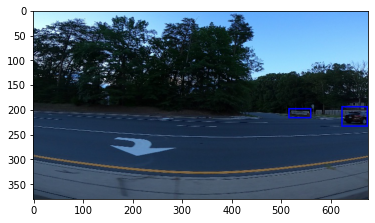

tensor([[295.5769, 188.4728, 458.2254, 249.9647],
        [526.9515, 189.0581, 632.4412, 230.2511],
        [529.4457, 193.1264, 577.0078, 217.5241]], grad_fn=<StackBackward0>)


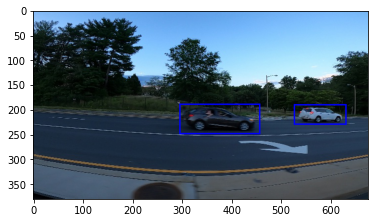

tensor([[384.5799, 174.7794, 508.8706, 223.1892]], grad_fn=<StackBackward0>)


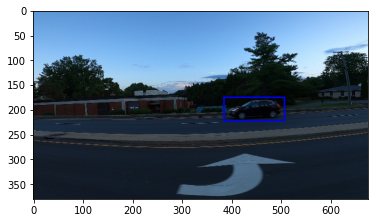

tensor([[422.6185, 191.5697, 547.6366, 235.3078]], grad_fn=<StackBackward0>)


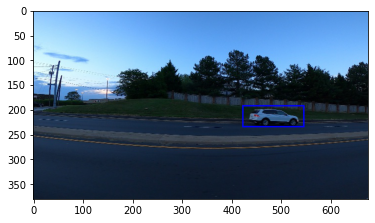

tensor([[472.4273, 187.9064, 606.3484, 239.6273],
        [  0.0000, 180.9258,  92.1064, 240.5937],
        [631.5137, 196.8111, 673.2469, 229.9863]], grad_fn=<StackBackward0>)


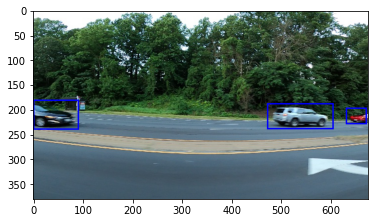

tensor([[506.0244, 195.2587, 603.0044, 233.7928],
        [508.6179, 197.3567, 569.4223, 226.5261]], grad_fn=<StackBackward0>)


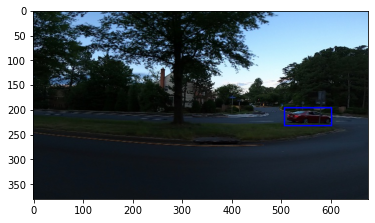

tensor([[387.2761, 175.6224, 578.8906, 244.3723],
        [395.2389, 196.1016, 466.0950, 229.1416]], grad_fn=<StackBackward0>)


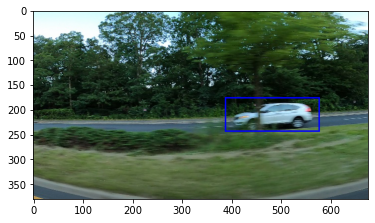

tensor([[607.6931, 197.0711, 672.6503, 229.0865],
        [  0.0000, 168.6459,  67.1970, 215.2449],
        [321.0745, 173.7187, 383.9128, 214.0509]], grad_fn=<StackBackward0>)


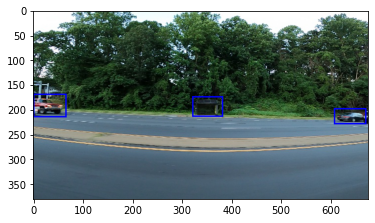

tensor([[0.0000e+00, 1.6790e+02, 5.6182e+01, 2.1302e+02],
        [6.4449e-02, 1.4506e+02, 5.2917e+01, 1.8847e+02]],
       grad_fn=<StackBackward0>)


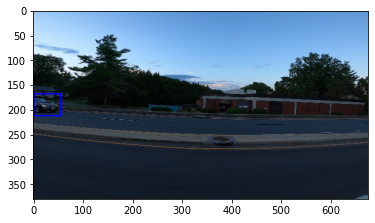

In [21]:
def visualize_predicted_bb(dataset,model,indxs):
    for i in indxs:
        image,target,default_img= dataset[i]
        image = image.unsqueeze(0)
        #device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
        
        device = torch.device("cpu")
        image = image.to(device)
        model = model.to(device)
        
        model.eval()
        preds = model(image)

        boxes = preds[0]['boxes']
        print(boxes)
        #Choosing Bounding Boxes which have a minimum IoU of 0.1
        #keep stores indices of bounding boxes with IoU<0.1
        keep = torchvision.ops.nms(boxes,preds[0]['scores'],0.1)
        default_img *= 255
        resulting_img = draw_bounding_boxes(default_img.byte(),boxes[keep],colors = "blue",width=3)
        plt.imshow(resulting_img.permute(1,2,0))
        plt.show()
        
visualize_predicted_bb(val_dataset,model,[i for i in range(10)])